(code inspired by https://github.com/SmileYuhao/concept-drift)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier

from skmultiflow.drift_detection.adwin import ADWIN
from skmultiflow.drift_detection.page_hinkley import PageHinkley

In [2]:
def read_data(filename):
    df = pd.read_csv(filename)
    data = df.values
    return data[:, :-1], data[:, -1]

# Incremental Training

A classifier that replaces the current classifier with one that supports `partial_fit` and does incremental training only on the samples passed.

`fit`: Fit linear model with Stochastic Gradient Descent. 
`partial_fit`: Perform one epoch of stochastic gradient descent on given samples.

In [3]:
""""Classifier that replaces the current classifier with a new one when a change is detected in accuracy.
"""
from sklearn import clone
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score


class DetectorClassifier(BaseEstimator):
    def __init__(self, clf, detection_method, classes):
        if not hasattr(clf, "partial_fit"):
            raise TypeError("Choose incremental classifier")
        self.clf = clf
        self.detection_method = detection_method
        self.classes = classes
        self.change_detected = 0

    def fit(self, X, y):
        self.clf.fit(X, y)
        return self

    def partial_fit(self, X, y):
        pre_y = self.clf.predict(X)
        self.detection_method.add_element(accuracy_score(pre_y, y))
        if self.detection_method.detected_change():
            self.change_detected += 1
            self.clf = clone(self.clf)
            self.clf.partial_fit(X, y, classes=self.classes)
        else:
            self.clf.partial_fit(X, y)

    def predict(self, X):
        return self.clf.predict(X)

# Prequential Evaluation

In data stream mining, the most used evaluation scheme is the prequential or interleaved-test-then-train evolution. The idea is very simple: we use each instance first to test the model, and then to train the model.

In [4]:
from time import clock

import numpy as np


def prequential(X, y, clf, n_train=1):
    """Prequential Evaluation: instances are first used to test, and then to train
    :return the label predictions for each test instance, and the associated running time
    """
    row_num = y.shape[0]
    # Split an init batch
    X_init = X[0:n_train]
    y_init = y[0:n_train]

    # Used for training and evaluation
    X_train = X[n_train:]
    y_train = y[n_train:]

    y_pre = np.zeros(row_num - n_train)
    time = np.zeros(row_num - n_train)

    clf.fit(X_init, y_init)

    for i in range(0, row_num - n_train):
        start_time = clock()
        y_pre[i] = clf.predict(X_train[i, :].reshape(1, -1))
        clf.partial_fit(X_train[i, :].reshape(1, -1), y_train[i].reshape(1, -1).ravel())
        time[i] = clock() - start_time

    return y_pre, time


SGDClassifier:


/Users/debasishghosh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


Mean acc within the window 10000: 0.8412686049247499

Page-Hinkley:


/Users/debasishghosh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


Drift detection: 2
Mean acc within the window 10000: 0.9859824118697018

AdWin:


/Users/debasishghosh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


Drift detection: 46
Mean acc within the window 10000: 0.9922927325463476


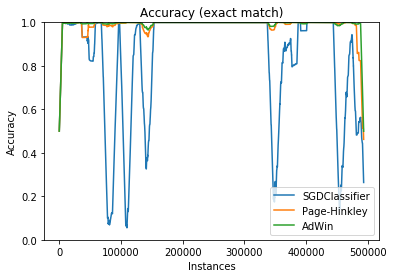

In [5]:
if __name__ == '__main__':
    n_train = 1000
    X, y = read_data("data/kddcup_refactored.csv")
    # Set x,y as numeric
    X = X.astype(float)
    label = ["normal.", "abnormal."]
    
    le = preprocessing.LabelEncoder()
    le.fit(label)
    y = le.transform(y)

    w = 10000

    clfs = [
        SGDClassifier(),
        DetectorClassifier(SGDClassifier(), PageHinkley(), np.unique(y)),
        DetectorClassifier(SGDClassifier(), ADWIN(), np.unique(y))
    ]
    clfs_label = ["SGDClassifier", "Page-Hinkley", "AdWin"]

    plt.title("Accuracy (exact match)")
    plt.xlabel("Instances")
    plt.ylabel("Accuracy")

    for i in range(len(clfs)):
        print("\n{}:".format(clfs_label[i]))
        with np.errstate(divide='ignore', invalid='ignore'):
            y_pre, time = prequential(X, y, clfs[i], n_train)
        if clfs[i].__class__.__name__ == "DetectorClassifier":
            print("Drift detection: {}".format(clfs[i].change_detected))
        estimator = (y[n_train:] == y_pre) * 1

        acc_run = np.convolve(estimator, np.ones((w,)) / w, 'same')
        print("Mean acc within the window {}: {}".format(w, np.mean(acc_run)))
        plt.plot(acc_run, "-", label=clfs_label[i])

    plt.legend(loc='lower right')
    plt.ylim([0, 1])
    plt.show()